# Transient Attributes Analyses

Code for the analyses made in sections **IV.I - Transient Attribute Influence Analysis** and the **Supplementary Material - VII - Transient Attributes**. 



### Setup

In [1]:
# !pip install --upgrade scikit-image
# !pip install pyproj
# !pip install tqdm

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os, sys

from itertools import product
import matplotlib.image as mpimg
import pyproj
from tqdm import tqdm

from skimage import transform

sys.path.append("../../datasets")
from dataLoader import DataLoader, preprocess_time

from tf.keras.models import Model, load_model
from tf.keras.layers import Input
from tf.keras.losses import mean_squared_error

transLabels = ["dirty", "daylight", "night", "sunrisesunset", "dawndusk", "sunny", "clouds", 
               "fog", "storm", "snow", "warm", "cold", "busy", "beautiful", "flowers", "spring", 
               "summer", "autumn", "winter", "glowing", "colorful", "dull", "rugged", "midday", 
               "dark", "bright", "dry", "moist", "windy", "rain", "ice", "cluttered", "soothing", 
               "stressful", "exciting", "sentimental", "mysterious", "boring", "gloomy", "lush"]

transCategories = {"Illumination":["dark","glowing","bright"],
               "Period of the day":["daylight", "night", "sunrisesunset", "dawndusk","midday"],
               "Weather":["sunny", "clouds","fog", "storm", "snow", "warm", "cold", "dry", 
                          "moist", "windy", "rain", "ice" ],
               "Season":["spring", "summer", "autumn", "winter"],
               "Vegetation":["flowers", "lush"],
               "Colors":["colorful", "dull"],
               "Appearance":["dirty", "busy", "rugged", "cluttered"],
               "Subjective":["beautiful", "soothing", "stressful", "exciting", "sentimental", 
                             "mysterious", "boring", "gloomy"]
               }


batchSize = 1
pathToModel = "../IV.B_ablation_study/denseNet/gr_oh_loc_time_TA/weights.30-0.57407.hdf5"
gpuNumber = 4

## GPU selection
import tensorflow as tf 
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[gpuNumber], 'GPU')
tf.config.experimental.set_memory_growth(gpus[gpuNumber], False)



#######################
##    Custom MSE     ##
#######################
# We will compute the MSE only for the consistent inputs
def transient_mse(y_true, y_pred):
    return tf.sum(mean_squared_error(y_true[0::2,:], y_pred[0::2,:]), axis=-1)



#######################
## Deprocess time
#######################
def deprocess_time(time):
    month, hour = time
    month = (11.0 / 2.0) * (month + 1) + 1
    hour = (23.0 / 2.0) * (hour + 1)
    return (int(round(month)), int(round(hour)))

def deprocess_loc(loc):
    _earth_radius = 6378137.0
    x,y,z = loc
    ecef = pyproj.Proj(proj='geocent', ellps='WGS84', datum='WGS84')
    lla = pyproj.Proj(proj='latlong', ellps='WGS84', datum='WGS84')
    
    lon, lat, alt = pyproj.transform(ecef, lla, x * _earth_radius, y*_earth_radius, z*_earth_radius, radians=False)
    return (lat, lon, alt)

Using TensorFlow backend.


### Load architecture

In [2]:
baseModel = load_model(pathToModel, custom_objects={"transient_mse": transient_mse})
print(baseModel.summary())

groundBranchModel = Model(baseModel.get_layer("groundInput").input, 
                          baseModel.get_layer("batch_normalization_2").output)
aerialBranchModel = Model(baseModel.get_layer("aerialInput").input, 
                          baseModel.get_layer("batch_normalization_4").output)
locBranchModel = Model(baseModel.get_layer("locationInput").input, 
                       baseModel.get_layer("batch_normalization_7").output)
timeBranchModel =  Model(baseModel.get_layer("timeInput").input, 
                         baseModel.get_layer("batch_normalization_10").output)

combinedFeaturesInput = Input(shape=(512,), name='concatenate_1_proxy')
consistFeatures = baseModel.get_layer("consist_fc1")(combinedFeaturesInput)
consistFeatures = baseModel.get_layer("batch_normalization_11")(consistFeatures)
consistFeatures = baseModel.get_layer("consist_fc2")(consistFeatures)
consistFeatures = baseModel.get_layer("batch_normalization_12")(consistFeatures)
consistFeatures = baseModel.get_layer("consist_fc3")(consistFeatures)
consistModel = Model(combinedFeaturesInput, consistFeatures)


grFeaturesInput = Input(shape=(128,), name='grFeaturesProxy')
grTransFeatures = baseModel.get_layer("gr_trans_fc1")(grFeaturesInput)
grTransFeatures = baseModel.get_layer("batch_normalization_13")(grTransFeatures)
grTransFeatures = baseModel.get_layer("gr_trans_fc2")(grTransFeatures)
grTransFeatures = baseModel.get_layer("batch_normalization_14")(grTransFeatures)
grTransPred = baseModel.get_layer("gr_trans_fc3")(grTransFeatures)
grTransModel = Model(grFeaturesInput, grTransPred)

combinedFeaturesInput = Input(shape=(384,), name='aeLocTimeFeaturesProxy')
combinedTransFeatures = baseModel.get_layer("ae_loc_time_trans_fc1")(combinedFeaturesInput)
combinedTransFeatures = baseModel.get_layer("batch_normalization_15")(combinedTransFeatures)
combinedTransFeatures = baseModel.get_layer("ae_loc_time_trans_fc2")(combinedTransFeatures)
combinedTransFeatures = baseModel.get_layer("batch_normalization_16")(combinedTransFeatures)
combinedTransPred = baseModel.get_layer("ae_loc_time_trans_fc3")(combinedTransFeatures)
combinedTransModel = Model(combinedFeaturesInput, combinedTransPred)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
groundInput (InputLayer)        (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
aerialInput (InputLayer)        (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
locationInput (InputLayer)      (None, 3)            0                                            
__________________________________________________________________________________________________
timeInput (InputLayer)          (None, 2)            0                                            
________

--------------
--------------
--------------
--------------


# Supplementary Material - VIII - Transient Attributes

Evaluate the usefullness of each transient attribute to pinpoint if a sample is consistent or inconsistent.

In [3]:
dl = DataLoader("test", 
                includeLocation = True, 
                includeSatellite = True, 
                outputTransientAttributes = True)

consistentList = []
inconsistentList = []

idx=0
pbar = tqdm(total=25000)

for batch, _ in dl.loadTestDataInBatches(batchSize):    
    grImg, aeImg, locInfo, timeInfo = [batch[i][0:1] for i in range(len(batch))]
    _, _, _, fakeTimeInfo = [batch[i][1:2] for i in range(len(batch))]

    grFeatures = groundBranchModel.predict_on_batch(grImg)
    aeFeatures = aerialBranchModel.predict_on_batch(aeImg)
    locFeatures = locBranchModel.predict_on_batch(locInfo)
    timeFeatures = timeBranchModel.predict_on_batch(timeInfo)
    fakeTimeFeatures = timeBranchModel.predict_on_batch(fakeTimeInfo)

    
    
    ## Consistent sample
    concatFV = np.hstack((grFeatures, aeFeatures, locFeatures, timeFeatures))
    pred = consistModel.predict_on_batch(concatFV)
    consistentProb = pred[0][0]
    
    grTransPred = grTransModel.predict_on_batch(grFeatures)[0]    
    aeLocTimeFV = np.hstack((aeFeatures, locFeatures, timeFeatures))
    combinedTransPred = combinedTransModel.predict_on_batch(aeLocTimeFV)[0]

    consistentList += [(consistentProb, grTransPred, combinedTransPred)]
    
    
    ## Inconsistent sample
    concatFV = np.hstack((grFeatures, aeFeatures, locFeatures, fakeTimeFeatures))
    pred = consistModel.predict_on_batch(concatFV)
    consistentProb = pred[0][0]
     
    aeLocTimeFV = np.hstack((aeFeatures, locFeatures, fakeTimeFeatures))
    combinedTransPred = combinedTransModel.predict_on_batch(aeLocTimeFV)[0]
    
    inconsistentList += [(consistentProb, grTransPred, combinedTransPred)]
    
    
    idx += 1
    pbar.update(1)
   
        
sortedConsistentList = [x for x in sorted(consistentList, 
                                              key=lambda triplet: triplet[0], reverse=True)]

sortedInconsistentList = [x for x in sorted(inconsistentList, 
                                              key=lambda triplet: triplet[0], reverse=False)]

100%|█████████▉| 24931/25000 [54:07<00:08,  7.89it/s]

# Finding the transient attributes that are most usefull

- Select all inconsistent samples with a confidence between `bottomConfidenteCutoffPoint` and `topConfidenteCutoffPoint`

- Find the attributes with the most average absolute difference (MAE) between aG and aS

In [4]:
topConfidenteCutoffPoint = 1.0
bottomConfidenteCutoffPoint = 0.8

filteredList = np.array([np.abs(d[1] - d[2]) for d in sortedInconsistentList if bottomConfidenteCutoffPoint <= 1.0 - d[0] <= topConfidenteCutoffPoint])
meanAbsoluteDifferencePerAttribute = np.mean(filteredList, axis=0)


orderedAttributes = [(transLabels[p[0]], p[1]) for p in sorted(list(enumerate(meanAbsoluteDifferencePerAttribute)), 
                                              key=lambda pair: pair[1], reverse=True)]

print("Top 15 attributes with higher mean absolute difference between aG and aS")
for ta, mae in orderedAttributes[:15]:
    print ta, "\t\t", mae

print("\n\nRanking of categories \t\t(the lower the better)")
categoryRanking = [0 for _ in transCategories]

for rank, x in enumerate(orderedAttributes):
    ta = x[0]
    
    for catIdx, attributeList in enumerate(transCategories.values()):
        if ta in attributeList:
            categoryRanking[catIdx] += rank / float(len(attributeList))
            break

            
orderedCategories = [(transCategories.keys()[p[0]], p[1]) for p in sorted(list(enumerate(categoryRanking)), 
                                                                          key=lambda pair: pair[1], reverse=False)]
            
for catName, ranking in orderedCategories:
    print(catName, "\t\t\t\t", ranking)

Top 15 attributes with higher mean absolute difference between aG and aS
snow 		0.21270165
winter 		0.20904224
ice 		0.20816617
cold 		0.20404322
dry 		0.19490701
lush 		0.19192418
summer 		0.17725524
moist 		0.17217226
sunny 		0.16184948
busy 		0.15459003
colorful 		0.15162702
daylight 		0.13584678
warm 		0.13327956
bright 		0.12675393
spring 		0.119359665


Ranking of categories 		(the lower the better)
Season 				12.25
Colors 				12.5
Weather 				16.0
Illumination 				16.6666666667
Vegetation 				17.0
Appearance 				18.5
Period of the day 				23.0
Subjective 				30.125


# Formalizing the comparison between aG and aS

Compute the mean absolute distance between aG and aS for high confidence consistent samples and high confidence inconsistent samples:

In [57]:
confidenceList = np.arange(0.50, 1.05, 0.05)


consistentDist = []
inconsistentDist = []
for binIdx in range(1, len(confidenceList)):
    previousCutoffPoint = confidenceList[binIdx-1]
    cutoffPoint = confidenceList[binIdx]
    meanAbsDistInconsistent = np.mean([np.abs(d[1] - d[2]) for d in sortedInconsistentList 
                                       if previousCutoffPoint < 1.0 - d[0] <= cutoffPoint])

    inconsistentDist += [meanAbsDistInconsistent]
    
    meanAbsDistConsistent = np.mean([np.abs(d[1] - d[2]) for d in sortedConsistentList 
                                     if previousCutoffPoint < d[0] <= cutoffPoint])
    
    consistentDist += [meanAbsDistConsistent]
    

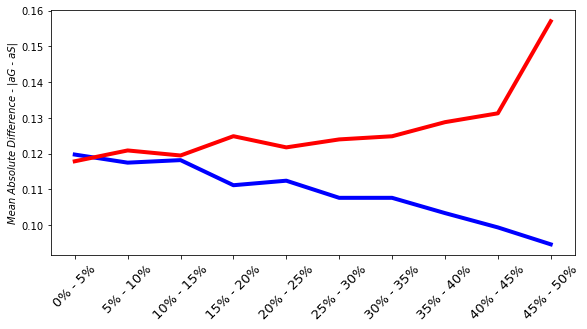

In [58]:
fig=plt.figure(figsize=(8,4))
columns = 1
rows = 1

fig.add_subplot(rows, columns, 1)
fig.tight_layout()

plt.xticks(range(len(confidenceList)-1), 
           ["{:d}% - {:d}%".format(x,x+5) for x in range(0, 100, 5)],
           size=13, rotation=45)

plt.ylabel("Mean Absolute Difference - |aG - aS|", fontstyle= "oblique")




plt.plot(range(len(confidenceList)-1), consistentDist, lw=4, c='b')
plt.plot(range(len(confidenceList)-1), inconsistentDist, lw=4, c='r')
plt.show()

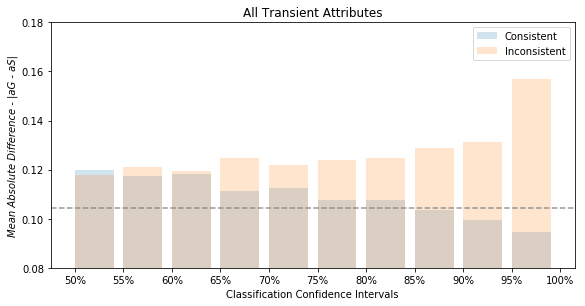

In [59]:
fig=plt.figure(figsize=(8,4))
columns = 1
rows = 1

fig.add_subplot(rows, columns, 1)
fig.tight_layout()

plt.xticks(range(len(confidenceList)), 
           ["{0:d}%".format(x,x+5) for x in range(50, 105, 5)])
plt.ylim((0.08, 0.18))
plt.title("All Transient Attributes")
plt.ylabel("Mean Absolute Difference - |aG - aS|", fontstyle= "oblique")
plt.xlabel("Classification Confidence Intervals")

plt.bar(range(len(confidenceList)-1), consistentDist, align = "edge", alpha=0.2, label="Consistent")
plt.bar(range(len(confidenceList)-1), inconsistentDist, align = "edge", alpha=0.2, label="Inconsistent")
plt.axhline(y=0.1043887147, color='grey', alpha=0.8, linestyle='--')

plt.legend()

plt.show()

### Considering only Illumination, Colors and Period of the day features

In [60]:
attributesOfInterest = transCategories["Illumination"] + \
                        transCategories["Period of the day"] + \
                        transCategories["Colors"]


weights = np.array([1.0 if att in attributesOfInterest else 0.0 for att in  transLabels])

In [61]:
confidenceList = np.arange(0.50, 1.05, 0.05)


consistentDist = []
inconsistentDist = []
for binIdx in range(1, len(confidenceList)):
    previousCutoffPoint = confidenceList[binIdx-1]
    cutoffPoint = confidenceList[binIdx]
    absDistInconsistent = [weights * np.abs(d[1] - d[2]) for d in sortedInconsistentList 
                                       if previousCutoffPoint < 1.0 - d[0] <= cutoffPoint]
    meanAbsDistInconsistent = np.nanmean(np.where(absDistInconsistent!=0,absDistInconsistent,np.nan))

    inconsistentDist += [meanAbsDistInconsistent]
    
    absDistConsistent = [weights * np.abs(d[1] - d[2]) for d in sortedConsistentList 
                                     if previousCutoffPoint < d[0] <= cutoffPoint]
    meanAbsDistConsistent = np.nanmean(np.where(absDistConsistent!=0,absDistConsistent,np.nan))
    
    consistentDist += [meanAbsDistConsistent]
    

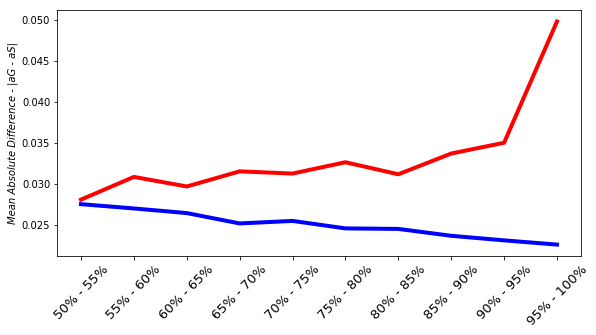

In [62]:
fig=plt.figure(figsize=(8,4))
columns = 1
rows = 1

fig.add_subplot(rows, columns, 1)
fig.tight_layout()

plt.xticks(range(len(confidenceList)-1), 
           ["{:d}% - {:d}%".format(x,x+5) for x in range(50, 100, 5)],
           size=13, rotation=45)

plt.ylabel("Mean Absolute Difference - |aG - aS|", fontstyle= "oblique")
# plt.xlabel("Consistent Probability Intervals")



plt.plot(range(len(confidenceList)-1), consistentDist, lw=4, c='b')
plt.plot(range(len(confidenceList)-1), inconsistentDist, lw=4, c='r')
plt.show()

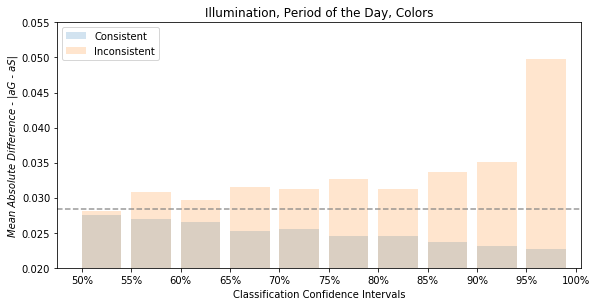

In [63]:
fig=plt.figure(figsize=(8,4))
columns = 1
rows = 1

fig.add_subplot(rows, columns, 1)
fig.tight_layout()

plt.xticks(range(len(confidenceList)), 
           ["{0:d}%".format(x,x+5) for x in range(50, 105, 5)])
plt.xlim((-0.5,len(confidenceList)-1 +0.1))
plt.ylim((0.02, 0.055))
plt.title("Illumination, Period of the Day, Colors")
plt.ylabel("Mean Absolute Difference - |aG - aS|", fontstyle= "oblique")
plt.xlabel("Classification Confidence Intervals")

plt.bar(range(len(confidenceList)-1), consistentDist, align = "edge", alpha=0.2, label="Consistent")
plt.bar(range(len(confidenceList)-1), inconsistentDist, align = "edge", alpha=0.2, label="Inconsistent")
plt.axhline(y=0.02845674487, color='grey', alpha=0.8, linestyle='--')


plt.legend()

plt.show()

--------------
--------------
--------------
--------------


# IV.I - Transient Attribute Influence Analysis

Evaluate the mutual information between aG and aS for consistent and inconsistent samples

### Mutual Information definition

In [ ]:
from scipy import ndimage

def mutual_information_2d(x, y, sigma=1, normalized=False, nBins=100):
    """
    Computes (normalized) mutual information between two 1D variate from a
    joint histogram.
    Parameters
    ----------
    x : 1D array
        first variable
    y : 1D array
        second variable
    sigma: float
        sigma for Gaussian smoothing of the joint histogram
    Returns
    -------
    nmi: float
        the computed similariy measure
    """
    bins = (nBins, nBins)
    EPS = np.finfo(float).eps

    jh = np.histogram2d(x, y, bins=bins)[0]

    # smooth the jh with a gaussian filter of given sigma
    ndimage.gaussian_filter(jh, sigma=sigma, mode='constant',
                                 output=jh)

    # compute marginal histograms
    jh = jh + EPS
    sh = np.sum(jh)
    jh = jh / sh
    s1 = np.sum(jh, axis=0).reshape((-1, jh.shape[0]))
    s2 = np.sum(jh, axis=1).reshape((jh.shape[1], -1))

    # Normalised Mutual Information of:
    # Studholme,  jhill & jhawkes (1998).
    # "A normalized entropy measure of 3-D medical image alignment".
    # in Proc. Medical Imaging 1998, vol. 3338, San Diego, CA, pp. 132-143.
    if normalized:
        mi = ((np.sum(s1 * np.log(s1)) + np.sum(s2 * np.log(s2)))
                / np.sum(jh * np.log(jh))) - 1
    else:
        mi = ( np.sum(jh * np.log(jh)) - np.sum(s1 * np.log(s1))
               - np.sum(s2 * np.log(s2)))

    return mi

For a single transient attribute, compute aG and aS for every image in train/test. Compute a 2-D histogram (aG and aS) for tampered and real samples. 

In [ ]:
realProbList = []
realAttributeList = [[] for _ in transLabels]

tamperedProbList = []
tamperedAttributeList = [[] for _ in transLabels]

bIdx = 0
for batch, label in dl.loadTestDataInBatches(batchSize):
    pred, grAtr, aeLocTimeAtr = baseModel.predict(batch)

    bIdx += 1
    for idx in range(len(transLabels)):
        realAttributeList[idx].append((grAtr[0,idx], aeLocTimeAtr[0,idx]))
        tamperedAttributeList[idx].append((grAtr[1,idx], aeLocTimeAtr[1,idx]))
    
    realProbList.append(pred[0][0])
    tamperedProbList.append(pred[1][1])
        
    if (bIdx % 100) == 0:
        print(bIdx, " / 25000")
        
realAttributeList = np.array(realAttributeList)
tamperedAttributeList = np.array(tamperedAttributeList)
realProbList = np.array(realProbList)
tamperedProbList = np.array(tamperedProbList)



original_realAttributeList = np.copy(realAttributeList)
original_tamperedAttributeList = np.copy(tamperedAttributeList)

Filtering samples that were classified with a high confidence

In [ ]:
### Filter those with high prob
thresholdProb = 0.90
realAttributeList = np.copy(original_realAttributeList)
tamperedAttributeList = np.copy(original_tamperedAttributeList)

print(original_realAttributeList.shape, original_tamperedAttributeList.shape, realProbList.shape)

realAttributeList = realAttributeList[:, realProbList > thresholdProb, :]
tamperedAttributeList = tamperedAttributeList[:,tamperedProbList > thresholdProb,:]

print(original_realAttributeList.shape, realAttributeList.shape)
print(original_tamperedAttributeList.shape, tamperedAttributeList.shape)

Compute the mutual information

In [ ]:
nBins = 15

mInfoList = []
y = []
for idx,attributeName in enumerate(transLabels):
    realMI =  mutual_information_2d(realAttributeList[idx, :, 0], realAttributeList[idx, :, 1], 
                                    normalized=True, nBins=nBins)
    tampMI =  mutual_information_2d(tamperedAttributeList[idx, :, 0], tamperedAttributeList[idx, :, 1], 
                                    normalized=True, nBins=nBins)
    y.append((realMI, tampMI))
    mInfoList.append(realMI - tampMI)

sortedIdx = [x for _,x in sorted(zip(mInfoList,list(range(len(transLabels)))))][::-1]

for idx in sortedIdx:
    print(transLabels[idx], " : ", mInfoList[idx]) #, "\t", y[idx][0], y[idx][1])

Plot heatmap:

In [ ]:
for idx in sortedIdx:
    attributeName = transLabels[idx]
    fig = plt.figure()
    
    H, xedges, yedges = np.histogram2d(realAttributeList[idx, :, 0], realAttributeList[idx, :, 1],
                                       bins=nBins, range=[[0, 1.0], [0.0, 1.0]])
    H = H/np.max(H)
    fig.add_subplot(121, title='Real - ' + attributeName, 
                         aspect='equal', xlim=xedges[[0, -1]], ylim=yedges[[0, -1]])

    plt.imshow(H, interpolation='nearest', origin='low', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

    
    
    fig.add_subplot(122, title='Tamp - ' + attributeName, 
                         aspect='equal', xlim=xedges[[0, -1]], ylim=yedges[[0, -1]])
    H, xedges, yedges = np.histogram2d(tamperedAttributeList[idx, :, 0], tamperedAttributeList[idx, :, 1],
                                       bins=nBins, range=[[0, 1.0], [0.0, 1.0]])
    H = H/np.max(H)

    plt.imshow(H, interpolation='nearest', origin='low', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

Visualize the distribution:

In [ ]:
nBins = 15

for idx in sortedIdx:
    attributeName = transLabels[idx]
    fig = plt.figure()
    
    rDist = np.abs(realAttributeList[idx, :, 0] - realAttributeList[idx, :, 1])
    tDist = np.abs(tamperedAttributeList[idx, :, 0] - tamperedAttributeList[idx, :, 1])

    plt.hist(rDist, nBins, alpha=0.5, label='consistent', density=True)
    plt.hist(tDist, nBins, alpha=0.5, label='inconsistent', density=True)
    plt.title(attributeName)
    plt.legend(loc='upper right')
    plt.savefig("attributes/dHist_" + attributeName + ".png", dpi=150)
    plt.show()

In [ ]:
nBins = 100
nToConsider = 5

def top_k_values(array):
    indexes = array.argsort()[-nToConsider:][::-1]
    A = set(indexes)
    B = set(list(range(array.shape[0])))
    array[list(B.difference(A))]=0
    return np.sum(array)


rDist = np.abs(realAttributeList[:, :, 0] - realAttributeList[:, :, 1]).T
tDist = np.abs(tamperedAttributeList[:, :, 0] - tamperedAttributeList[:, :, 1]).T

print(rDist.shape, tDist.shape)

rDist = np.apply_along_axis(top_k_values, 1, rDist)
tDist = np.apply_along_axis(top_k_values, 1, tDist)

print(rDist.shape, tDist.shape)
        
fig, axs = plt.subplots(1, 2, sharey=False, sharex=True, tight_layout=False)
axs[0].set_title('Real - top ' + str(nToConsider) + ' divergent att')
axs[0].hist(rDist, bins=nBins)

dist = np.abs(tamperedAttributeList[idx, :, 0] - tamperedAttributeList[idx, :, 1])
axs[1].set_title('Tamp - top ' + str(nToConsider) + ' divergent att')
axs[1].hist(tDist, bins=nBins)
plt.show()


plt.hist(rDist, nBins, alpha=0.5, label='real', density=True)
plt.hist(tDist, nBins, alpha=0.5, label='tamp', density=True)
plt.legend(loc='upper right')
plt.show()